In [1]:
###################################
## Seeds Classification Analysis ##
###################################

# The main goal of this analysis is to get a better understanding of the dataset
# and build a model that predicts the seed class

In [48]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.neighbors import KNeighborsClassifier as knnc
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats

In [49]:
# Load data
mydata = pd.read_csv("https://raw.githubusercontent.com/FerranDonoso/02-2020-Seeds-Data/master/seeds_dataset.txt",
                     delim_whitespace = True, header = None,
                     names = ["Area", "Perimeter", "Compactness", "Length_of_kernel", "Width_of_kernel",
                              "Asymmetry_coefficient", "Length_of_kernel_groove", "Class"])

In [50]:
# Get to know the data
mydata.describe()

# Here we can see statistical information for each variable, and get a better idea of the dataset

,Area,Perimeter,Compactness,Length_of_kernel,Width_of_kernel,Asymmetry_coefficient,Length_of_kernel_groove,Class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [51]:
# Get to know the data
mydata.info()

# A simple step justo to verify that each variable has the correct type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
Area                       210 non-null float64
Perimeter                  210 non-null float64
Compactness                210 non-null float64
Length_of_kernel           210 non-null float64
Width_of_kernel            210 non-null float64
Asymmetry_coefficient      210 non-null float64
Length_of_kernel_groove    210 non-null float64
Class                      210 non-null int64
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [52]:
# Convert Class into categorical
mydata["Class"] = list(pd.Categorical(mydata.Class))

# "Class" its not a numerical feature

In [53]:
# Define features and dependant variable
X = mydata[mydata.columns.difference(["Class"])]
y = mydata["Class"]

# Here I define which variables are going to be used as features to build the predictive model
# and which one is going to be the target of said prediction

In [54]:
# Normalize data sets
X = X.apply(lambda x: ((x - x.min()) / (x.max() - x.min())), axis = 0)

# Since we have many features with different scales and ranges
# I decided to normalize them between 0 and 1 maintaining the distance

In [55]:
# Check for missing values
mydata.isnull().sum().to_frame("Missing Values")

# Rutinary step to see if there is any missing value

,Missing Values
Area,0
Perimeter,0
Compactness,0
Length_of_kernel,0
Width_of_kernel,0
Asymmetry_coefficient,0
Length_of_kernel_groove,0
Class,0


In [56]:
# Check for duplicated rows
print("Duplicated Rows:", mydata.duplicated().sum())

# Rutinary step to see if there is any duplicated row

Duplicated Rows: 0


In [57]:
# Check feature variance
variance = X.var()
variance.to_frame("Variance")

# Here I get the variance of every feature,
# since all of them are normalized, we can compare the variance between features
# and see which ones have more dispersed values relative to eachother

,Variance
Area,0.075493
Asymmetry_coefficient,0.038220
Compactness,0.045977
Length_of_kernel,0.062237
Length_of_kernel_groove,0.058559
Perimeter,0.072806
Width_of_kernel,0.072479


In [58]:
# Check class balance
mydata["Class"].value_counts().to_frame()

# To get a better grasp about the distribution of each class

,Class
3,70
2,70
1,70


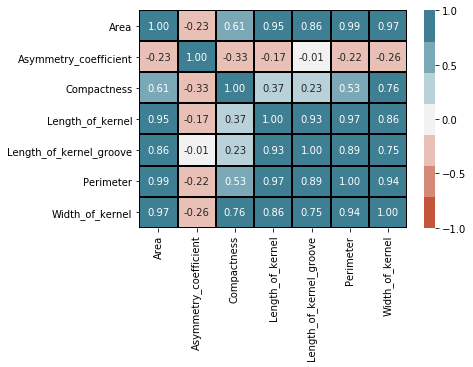

In [59]:
# Correlation matrix between features
corr = X.corr()
ax = sn.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = sn.diverging_palette(20, 220, n = 7),
                fmt = ".2f", linewidths = 1, linecolor = "black", annot = True,
                cbar_kws = {"ticks" : [-1, -.5, 0, 0.5, 1]})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Here we can see how the different features in the dataset are correlated to eachother
# -1 and 1 meaning a highly negative/positive relation respectively and 0 not related at all
# normaly it would be very interesting to have the target variable in this type of plot
# but this plot only works for numerical variables
# so we will just be be looking for features that are highly correlated with other features
# having these correlations wont be good for the predictive model, and we should break as many as we can
# and it seems that almost all of them are very correlated to eachother
# that can be explained because many features are measuring the proportions of each seed
# specialy "Area" and "Perimeter" seem to be very correlated to each other
# and to the rest of lenght an width features
# removing them will leave very few features, so for now I choose not to remove any

In [60]:
# Anova test between features and Class
Fval = []
pval = []
colN = list(mydata.columns.difference(["Class"]))

for i in colN:
    df = mydata[[i, "Class"]]
    F, p = stats.f_oneway(df[df.Class == 1][i],
                          df[df.Class == 2][i],
                          df[df.Class == 3][i])
    Fval.append(F)
    pval.append(p)

pd.DataFrame(list(zip(colN, Fval, pval)), columns = ["Feature", "Fval", "pval"])

# This test serves two purposes:
# -check if the p-value is under the 00.05 level of significance
# -check which features tells us the most about "Class" by looking at the F-value
# (the higher, the better)
# so all of the p-values are under 0.05
# and the best predictors are "Area" and "Perimeter"

,Feature,Fval,pval
0,Area,548.186479,1.964806e-83
1,Asymmetry_coefficient,51.888109,5.427325e-19
2,Compactness,75.869048,1.920700e-25
3,Length_of_kernel,322.185934,2.726363e-64
4,Length_of_kernel_groove,368.950045,5.629776e-69
5,Perimeter,541.579497,5.640999e-83
6,Width_of_kernel,406.302031,2.139265e-72


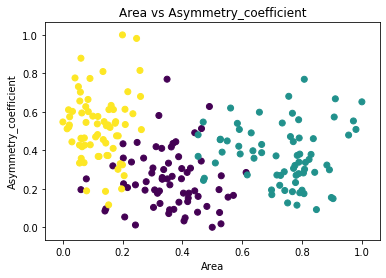

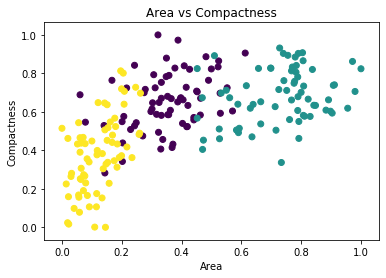

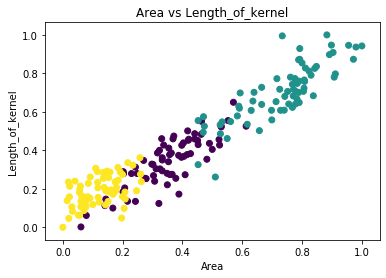

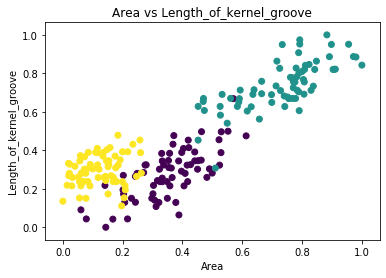

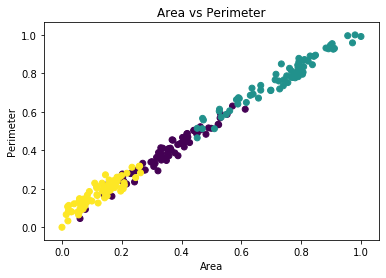

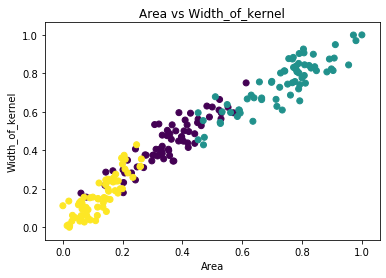

In [61]:
# Scatter plot area vs features colored by Class
x_col = "Area"
y_columns = list(X[X.columns.difference(["Area"])])

for y_col in y_columns:
    figure = plt.figure
    ax = plt.gca()
    ax.scatter(X[x_col], X[y_col], c = mydata["Class"])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))
    plt.show()
    
# Here we can see how each feature is related to "Area" colored by "Class"

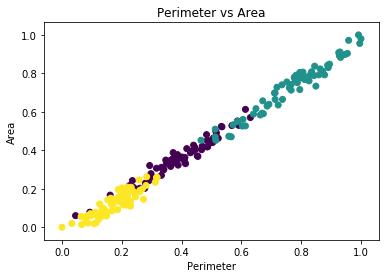

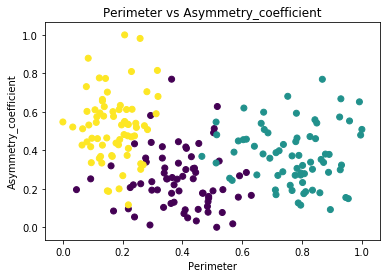

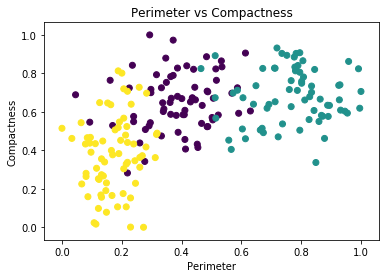

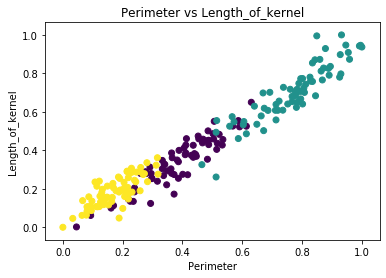

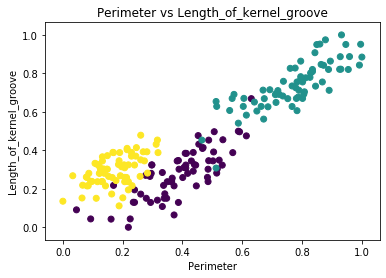

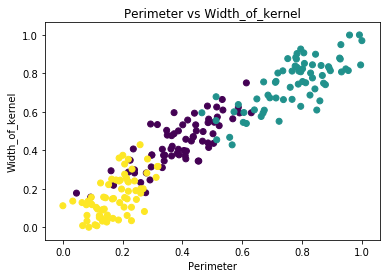

In [62]:
# Scatter plot perimeter vs features colored by Class
x_col = "Perimeter"
y_columns = list(X[X.columns.difference(["Perimeter"])])

for y_col in y_columns:
    figure = plt.figure
    ax = plt.gca()
    ax.scatter(X[x_col], X[y_col], c = mydata["Class"])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))
    plt.show()

# Here we can see how each feature is related to "Perimeter" colored by "Class"

In [63]:
# Remove "Area" and "Perimeter"
features = ["Compactness", "Length_of_kernel", "Width_of_kernel", "Asymmetry_coefficient", "Length_of_kernel_groove"]

# "Area" and "Perimeter" are very correlated to eachother
# that means that both features are giving almost the same information to every observation
# so its like have a duplicated row
# also these two features seem to be a calculation of the other features
# thats why they are so correlated

In [64]:
# Define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# Here I split the dataset 70% to train the model and 30% to test it

In [65]:
# Train shape
X_train.shape, y_train.shape

((147, 7), (147,))

In [66]:
# Test shape
X_test.shape, y_test.shape

((63, 7), (63,))

In [67]:
# Add cross-validation step
kf = KFold(n_splits = 10)

# Since the dataset doesnt have many observations I decided to add this step to get more robust train metrics

In [68]:
# Naive bayes for reference
clf0 = gnb()
clf0.fit(X_train[features], y_train)

# Define and train model on train set

GaussianNB(priors=None, var_smoothing=1e-09)

In [69]:
# Predictions
y_pred0 = clf0.predict(X_test[features])

# Use the model to make predictions on test set

In [70]:
# Test error metrics
print("Test Error Metrics" "\n" "Accuracy:" "\t" "%.3f" % metrics.accuracy_score(y_test, y_pred0), "\n"
      "Kappa:" "\t" "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred0))

# Check model perfomance
# this first model is just to have a reference point
# and see how much better a tuned model performs

Test Error Metrics
Accuracy:	0.905 
Kappa:		0.849


In [71]:
# Random forest
clf = rfc(n_estimators = 500, random_state = 123)
clf.fit(X_train[features], y_train)

# Define and train model on train set

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [72]:
# Cross-validation error metrics
scores = cross_val_score(clf, X_train[features].values, y_train.values, cv = kf, scoring = "accuracy")

print("Train Accuracy", "\n"
      "Scores:" "\t", list(np.sort(np.around(scores, decimals = 3))), "\n"
      "Range:" "\t", "%.3f" % (scores.max() - scores.min()), "\n"
      "Mean:" "\t", "%.3f" % scores.mean())

# Here we can see the Accuracy of each repetition of the cross-validation step
# the range between the max and minimun and its mean
# these are just to evaluate the performance on the train set

Train Accuracy 
Scores:	 [0.714, 0.867, 0.867, 0.933, 0.933, 1.0, 1.0, 1.0, 1.0, 1.0] 
Range:	 0.286 
Mean:	 0.931


In [73]:
# Predictions
y_pred = clf.predict(X_test[features])

# Use the model to make predictions on the test set

In [74]:
# Confusion matrix
labels = np.unique(y_test)
results = metrics.confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(results, index = labels, columns = labels)

print("Test Error Metrics" "\n" "\n" "Confusion Matrix:")
print(cm, "\n", "\n"
      "Accuracy Score:" "\t" "%.3f" % metrics.accuracy_score(y_test, y_pred), "\n"
      "Kappa Score:" "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred), "\n", "\n"
      "Report:", "\n",
      metrics.classification_report(y_test, y_pred))

# Here we have the error metrics of the predictions made by the model
# the Accuracy is very close to the Train, thats good, it means that there is no overfitting
# at the confusion matrix we can see success predictions at the diagonal
# and errors elsewhere
# row headers are the values that the model predicted
# and columns headers are the actual values

Test Error Metrics

Confusion Matrix:
    1   2   3
1  15   1   1
2   0  15   0
3   3   0  28 
 
Accuracy Score:	0.921 
Kappa Score:	0.875 
 
Report: 
               precision    recall  f1-score   support

           1       0.83      0.88      0.86        17
           2       0.94      1.00      0.97        15
           3       0.97      0.90      0.93        31

    accuracy                           0.92        63
   macro avg       0.91      0.93      0.92        63
weighted avg       0.92      0.92      0.92        63



In [75]:
# Optimal k
aa = list(range(1, 10))

for i in aa:
    clf1 = knnc(n_neighbors = i)
    clf1.fit(X_train[features], y_train)
    y_pred1 = clf1.predict(X_test[features])
    print("Accuracy for", i, "neighbors:","%.3f" % metrics.accuracy_score(y_test, y_pred1))
    
# Here I made a loop to check the optimal value of K to train a K-NN model

Accuracy for 1 neighbors: 0.952
Accuracy for 2 neighbors: 0.873
Accuracy for 3 neighbors: 0.921
Accuracy for 4 neighbors: 0.889
Accuracy for 5 neighbors: 0.921
Accuracy for 6 neighbors: 0.905
Accuracy for 7 neighbors: 0.921
Accuracy for 8 neighbors: 0.905
Accuracy for 9 neighbors: 0.905


In [76]:
# Knn model with k = 1
clf1 = knnc(n_neighbors = 1)
clf1.fit(X_train[features], y_train)

# Define and train model on train set

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [77]:
# Cross-validation error metrics
scores1 = cross_val_score(clf1, X_train[features].values, y_train.values, cv = kf, scoring = "accuracy")

print("Train Accuracy", "\n"
      "Scores:" "\t", list(np.sort(np.around(scores1, decimals = 3))), "\n"
      "Range:" "\t", "%.3f" % (scores1.max() - scores1.min()), "\n"
      "Mean:" "\t", "%.3f" % scores1.mean())

# Here we can see the Accuracy of each repetition of the cross-validation step
# the range between the max and minimun and its mean
# these are just to evaluate the performance on the train set

Train Accuracy 
Scores:	 [0.733, 0.786, 0.867, 0.933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
Range:	 0.267 
Mean:	 0.932


In [78]:
# Predictions
y_pred1 = clf1.predict(X_test[features])

# Use the model to make predictions on the test set

In [79]:
# Confusion matrix
labels = np.unique(y_test)
results1 = metrics.confusion_matrix(y_test, y_pred1)
cm1 = pd.DataFrame(results1, index = labels, columns = labels)

print("Test Error Metrics" "\n" "\n" "Confusion Matrix:")
print(cm1, "\n", "\n"
      "Accuracy:" "\t" "%.3f" % metrics.accuracy_score(y_test, y_pred1), "\n"
      "Kappa:" "\t" "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred1), "\n", "\n"
      "Report:", "\n",
      metrics.classification_report(y_test, y_pred1))

# Here we have the error metrics of the predictions made by the model
# the Accuracy of the Test set is better than the Accuracy of the train set
# although its only slightly, that means that there is no overfitting and the model
# is very good at generalyzing
# at the confusion matrix we can see success predictions at the diagonal
# and errors elsewhere
# row headers are the values that the model predicted
# and columns headers are the actual values

Test Error Metrics

Confusion Matrix:
    1   2   3
1  17   0   0
2   0  15   0
3   3   0  28 
 
Accuracy:	0.952 
Kappa:		0.925 
 
Report: 
               precision    recall  f1-score   support

           1       0.85      1.00      0.92        17
           2       1.00      1.00      1.00        15
           3       1.00      0.90      0.95        31

    accuracy                           0.95        63
   macro avg       0.95      0.97      0.96        63
weighted avg       0.96      0.95      0.95        63



In [80]:
# Summary
print("\t""\t""\t""Naive Bayes", "\n"
      "Test Accuracy:""\t""\t""%.3f" % metrics.accuracy_score(y_test, y_pred0), "\n"
      "Test Kappa:" "\t" "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred0), "\n", "\n"
      "\t" "\t" "\t" "RF" "\t" "K-NN", "\n"
      "Train Accuracy Range:" "\t" "%.3f" % (scores.max() - scores.min()), "\t" "%.3f" % (scores1.max() - scores1.min()), "\n"
      "Train Accuracy Mean:" "\t" "%.3f" % scores.mean(), "\t" "%.3f" % scores1.mean(), "\n"
      "Test Accuracy:" "\t" "\t" "%.3f" % metrics.accuracy_score(y_test, y_pred), "\t" "%.3f" % metrics.accuracy_score(y_test, y_pred1), "\n"
      "Test Kappa:" "\t" "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred), "\t" "%.3f" % metrics.cohen_kappa_score(y_test, y_pred1))

# the reference model did quite well, so the tuned models didnt improve its performance metrics by much
# the K-NN model performs better in every level although just by a slight margin
# lower range and higher mean between train scores
# higher kappa and accuracy at test set
# based on the observations made above I will choose the K-NN model
# and for a better understanding of the model im going to look further into its errors

			Naive Bayes 
Test Accuracy:		0.905 
Test Kappa:		0.849 
 
			RF	K-NN 
Train Accuracy Range:	0.286 	0.267 
Train Accuracy Mean:	0.931 	0.932 
Test Accuracy:		0.921 	0.952 
Test Kappa:		0.875 	0.925


In [81]:
# Denormalize data
X_test = X_test.apply(lambda x: (x * (x.max() - x.min()) + x.min()), axis = 0)

# This step is just to see the real values of the following numbers instead of their normalized ones

In [82]:
# Add "Class" to test
X_test.loc[:, "Class"] = list(y_test.values)

In [83]:
# Add K-NN "Predictions" to test
X_test.loc[:, "Predictions"] = list(y_pred1)

In [84]:
# Add column "Error" color coded with correct and wrong predictions
X_test.loc[:, "Error"] = list(X_test.apply(lambda x: "Correct" if (x["Class"] == x["Predictions"]) else "Wrong", axis = 1))
X_test["Error"].value_counts()

# This column will label each observation with either "Correct" if the model predicted succesfuly
# or "Wrong" if not

Correct    60
Wrong       3
Name: Error, dtype: int64

In [85]:
# Rows with errors
X_test[X_test["Error"] == "Wrong"]

# Here we can see the rows of the test set where the model made an error

,Area,Asymmetry_coefficient,Compactness,Length_of_kernel,Length_of_kernel_groove,Perimeter,Width_of_kernel,Class,Predictions,Error
199,0.199105,0.291850,0.725832,0.097973,0.188986,0.192132,0.373931,3,1,Wrong
201,0.190848,0.236782,0.736504,0.047860,0.148907,0.180247,0.359686,3,1,Wrong
198,0.186260,0.341702,0.329299,0.287725,0.378066,0.249573,0.200142,3,1,Wrong


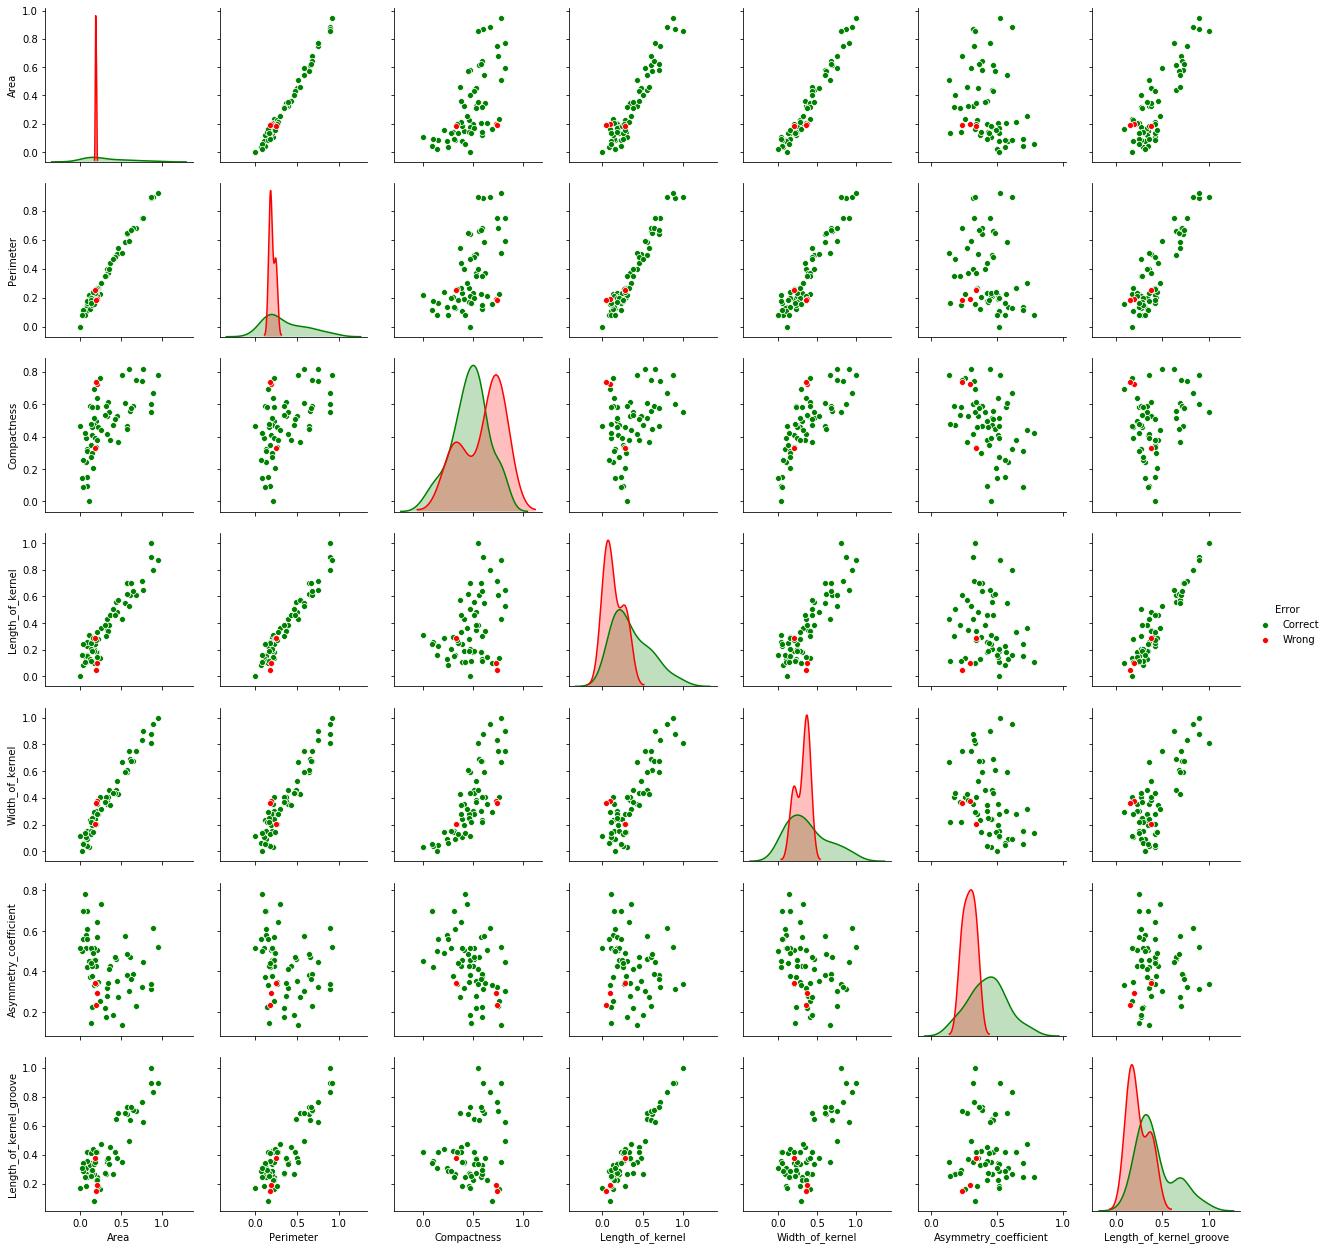

In [86]:
sn.pairplot(X_test, vars = ["Area", "Perimeter", "Compactness", "Length_of_kernel", "Width_of_kernel",
                            "Asymmetry_coefficient", "Length_of_kernel_groove"],
            hue = "Error", palette = dict(Correct = "green", Wrong = "red"))

# And here plots of every feature colored by the error type
# the errors have a very similar "Area", "Perimeter" and "Asymmetry_coefficient"

In [40]:
# What we have learned
# most features are correlated to eachother,
# thats because they all are measuring the proportions of each seed
# "Area" and "Perimeter" are the best predictors for "Class"
# but because they are very related we cannot use both
# also the other 3 features that are measuring lenght and width
# are very related to "Area" and "Perimeter"
# the K-NN model does pretty well, it has high kappa and accuracy and generalizes well
# the errors have a very similar "Area", "Perimeter" and "Asymmetry_coefficient"